## Target Testing

This Notebook intends to study the distribution of the target, assessing its pertinence and its capacity to accurately describe the financial trend. We will use different target parameters, such as the period, the goalreturn and the option logreturn in order to find which parameters most successfully describe the financial trend. 

Lastly, the best parameters will be defined as the default parameters of the method add_target 





In [2]:
import sys
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

In [3]:
from src.data_loader import load_data

spy = load_data()
spy.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
0,2000-01-03 00:00:00-05:00,93.388783,93.388783,90.632790,91.617073,8164300,0.0,0.0,0.0
1,2000-01-04 00:00:00-05:00,90.416197,90.750853,87.965333,88.034233,8089800,0.0,0.0,0.0
2,2000-01-05 00:00:00-05:00,88.152340,89.156308,86.459374,88.191711,12177900,0.0,0.0,0.0
3,2000-01-06 00:00:00-05:00,87.955531,89.136670,86.774391,86.774391,6227200,0.0,0.0,0.0
4,2000-01-07 00:00:00-05:00,88.388629,91.813934,88.231144,91.813934,8066500,0.0,0.0,0.0


In [4]:
from src.features import add_MA, add_EMA, add_returns, add_volatility, add_distances, add_cumulated_returns, add_rsi, add_target, add_all_features

df1 = spy.copy()
df1 = add_all_features(df1)
df1 = add_target(df1)

In [5]:
df1 = df1.drop(['Dividends', 'Stock Splits', 'Capital Gains'], axis=1)
df1.head()


,Date,Open,High,Low,Close,Volume,MA10,MA50,EMA20,Return,Log Return,Volatility,Distance_MA50,Distance_EMA20,Cumulated_Return_5d,RSI14,Trend
0,2000-01-03 00:00:00-05:00,93.388783,93.388783,90.632790,91.617073,8164300,NaN,NaN,91.617073,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,Non-Bullish
1,2000-01-04 00:00:00-05:00,90.416197,90.750853,87.965333,88.034233,8089800,NaN,NaN,89.736082,-0.039107,-0.039892,NaN,NaN,-0.018965,NaN,NaN,Bullish
2,2000-01-05 00:00:00-05:00,88.152340,89.156308,86.459374,88.191711,12177900,NaN,NaN,89.168998,0.001789,0.001787,NaN,NaN,-0.010960,NaN,NaN,Bullish
3,2000-01-06 00:00:00-05:00,87.955531,89.136670,86.774391,86.774391,6227200,NaN,NaN,88.477712,-0.016071,-0.016201,NaN,NaN,-0.019251,NaN,NaN,Bullish
4,2000-01-07 00:00:00-05:00,88.388629,91.813934,88.231144,91.813934,8066500,NaN,NaN,89.284716,0.058076,0.056453,NaN,NaN,0.028328,NaN,NaN,Non-Bullish


In [6]:
df1['Trend'].value_counts(normalize=True)

Trend
Non-Bullish    0.636609
Bullish        0.363391
Name: proportion, dtype: float64

In [7]:
dates = df1['Date'].astype(str).apply(lambda x: x[:4])
dates

date_trend_df = pd.DataFrame([dates, df1['Trend']]).T
date_trend_df['Trend'] = date_trend_df['Trend'].apply(lambda x: 1 if x == "Bullish" else 0)

infos = date_trend_df.groupby(['Date']).mean()
infos

,Trend
Date,
2000,0.119048
2001,0.193548
2002,0.115079
2003,0.678571
2004,0.222222
2005,0.186508
2006,0.390438
2007,0.183267
2008,0.059289


In [8]:
# Test on the functionning of the definition on other tickers

qqq = load_data(ticker = 'QQQ')
dow = load_data(ticker = 'DIA')

qqq = add_target(qqq)
dow = add_target(dow)
print(qqq['Trend'].value_counts(normalize=True))
print(dow['Trend'].value_counts(normalize=True))

Trend
Non-Bullish    0.557252
Bullish        0.442748
Name: proportion, dtype: float64
Trend
Non-Bullish    0.654739
Bullish        0.345261
Name: proportion, dtype: float64


Similar to the Dow Jones, less aggressive than the Nasdaq, the target seems coherent, now we will test if it is sensitive to a little gaussian noise on the price

Text(0.5, 1.0, 'Price of SPY along time with gaussian noise')

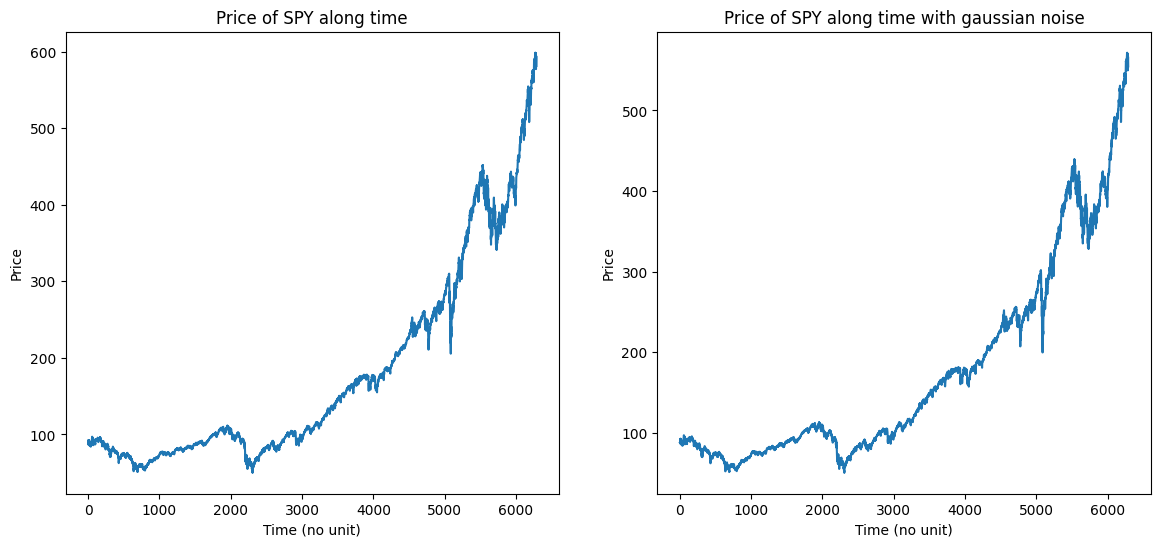

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#Add gaussian noise to logreturns and change the target accordingly

def add_gaussian(df: pd.DataFrame, mu = 0, sigma = 0.05):

    df1 = df.copy()

    #Add gaussian to logreturns
    sig = df1['Log Return'].std()
    norm_logreturns = df1['Log Return'] / sig

    rng = np.random.default_rng()
    s = rng.normal(mu, sigma, len(norm_logreturns))
    logreturns_noisy = s + norm_logreturns

    #Reconstruct price based on those new logreturns to change the target
    logreturns_noisy = logreturns_noisy * sig
    df1['Close'] = df1['Close'].iloc[0] * np.exp(logreturns_noisy.cumsum())

    df1 = df1.drop('Trend', axis=1)
    df1 = add_target(df1)

    return df1

gaussian_df_test = add_gaussian(df1)

fig, axes = plt.subplots(1, 2, figsize=(14,6))
axes[0].plot(df1['Close'])
axes[0].set_xlabel('Time (no unit)')
axes[0].set_ylabel('Price')
axes[0].set_title('Price of SPY along time')

axes[1].plot(gaussian_df_test['Close'])
axes[1].set_xlabel('Time (no unit)')
axes[1].set_ylabel('Price')
axes[1].set_title('Price of SPY along time with gaussian noise')




Text(0, 0.5, '|Pbullish_noisy - Pbullish_clean|')

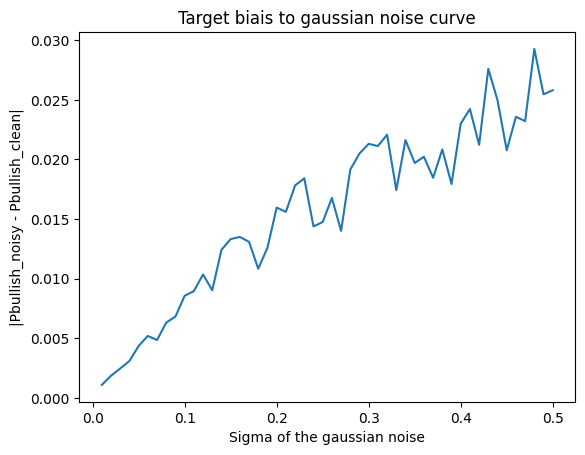

In [65]:
#Test of the gaussian noise on logreturns with sigmas from 0.01 to 0.5
#50 runs per sigma and compute the mean to normalize the results

sigmas = np.linspace(0.01, 0.5, 50)
p_bullish_clean = df1['Trend'].value_counts(normalize=True)['Bullish']
distances_noise_clean = []

n_runs = 50

for s in sigmas:
    vals = []
    for _ in range(n_runs):
        gaussian_df = add_gaussian(df1, sigma=s)
        p_noisy = gaussian_df['Trend'].value_counts(normalize=True)['Bullish']
        vals.append(abs(p_noisy - p_bullish_clean))
    distances_noise_clean.append(np.mean(vals))

plt.plot(sigmas, distances_noise_clean)
plt.title('Target biais to gaussian noise curve')
plt.xlabel('Sigma of the gaussian noise')
plt.ylabel('|Pbullish_noisy - Pbullish_clean|')



### Robustness Analysis of the Target

To evaluate the robustness of our binary trend target, we performed two complementary tests using Gaussian noise added to the log-returns of the SPY stock:

1. **Target Bias Curve (ΔP)**  
   - For each level of Gaussian noise σ ∈ [0.01, 0.5], we computed the absolute difference in the proportion of “Bullish” labels between the noisy and original series.  
   - Results show a maximal ΔP of ~3%, indicating that the global target proportion is largely insensitive to moderate noise.  
   - This suggests that the target captures a structural market trend rather than being sensitive to small fluctuations in price.


To complement the global metric, we will calculate the proportion of individual labels that change under noise (flip rate).  

**Conclusion:**  
The  analysis indicates that the target is robust at the macro level, with small global bias under noise. We might expect a sensitivity from the to be computed flip-rate curve

Text(0.5, 1.0, 'Flip Rate Curve | Stability of individual labels')

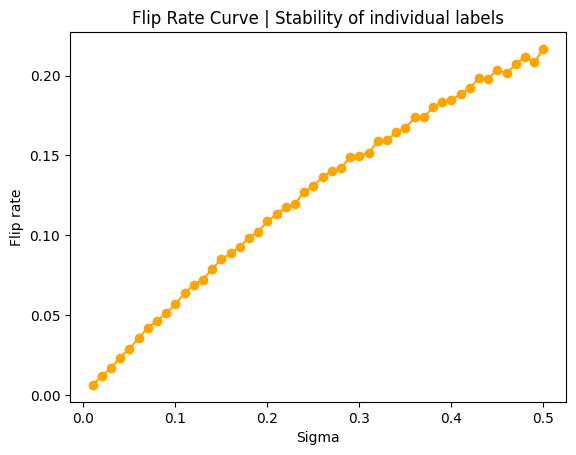

In [66]:
n_runs = 50  
flip_rates = []

for s in sigmas: #same sigma from the previous test
    flips = []
    for _ in range(n_runs):
        gaussian_df = add_gaussian(df1, sigma=s)  # pas de seed pour variation aléatoire
        flip_rate = (gaussian_df["Trend"] != df1["Trend"]).mean()
        flips.append(flip_rate)
    flip_rates.append(np.mean(flips))  # moyenne sur les runs

plt.plot(sigmas, flip_rates, marker='o', color='orange')
plt.xlabel('Sigma')
plt.ylabel('Flip rate')
plt.title('Flip Rate Curve | Stability of individual labels')

### Flip Rate Curve Analysis

The Flip Rate Curve shows that the proportion of individual labels changing under Gaussian noise increases roughly linearly from 1% to 22% as σ ranges from 0.01 to 0.5.  
This indicates that while the global target proportion remains largely stable, observations near the threshold are pretty sensitive to noise, highlighting local instabilities.  
Overall, the target is robust at the macro level, but micro-level label changes are expected in regions close to the 5% return threshold.

### Overall Target Robustness Conclusion

Combining insights from both the Target Bias Curve (ΔP) and the Flip Rate Curve:  

- **ΔP (Target Bias)** remains small (≤ 3%), showing minimal global shift in the proportion of Bullish labels under noise.  
- **Flip Rate** reveals that up to 20% of individual labels can change at higher σ, reflecting local sensitivity near the threshold.  

Together, these analyses confirm that the target definition captures the structural bullish trend robustly at a macro level, while preserving sensitivity to local variations, providing a balanced and reliable binary trend signal for the SPY series.
